<a href="https://colab.research.google.com/github/ooootaaaa/DeepLearning2022Late/blob/main/face_generation_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPooling2D, Dense, Activation, Flatten, Dropout, LeakyReLU

In [ ]:
# 本コードは下のセルのceleba_bldr.download_and_prepare()がエラーとなる場合は実行する
# ダウンロード済みのデータ(google driveに保存)を利用する
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p /root/tensorflow_datasets/downloads/manual/
!cp -f /content/drive/MyDrive/DeepLearning2/celeb_a/* /root/tensorflow_datasets/downloads/manual/

Mounted at /content/drive


In [ ]:
# データセットの準備
batch_size = 32
celeba_bldr = tfds.builder('celeb_a')
celeba_bldr.download_and_prepare()
celeba = celeba_bldr.as_dataset(shuffle_files=False)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/162770 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/celeb_a/2.0.1.incompleteLWREAV/celeb_a-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/19867 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/celeb_a/2.0.1.incompleteLWREAV/celeb_a-validation.tfrecord*...:   0%|     …

Generating test examples...:   0%|          | 0/19962 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/celeb_a/2.0.1.incompleteLWREAV/celeb_a-test.tfrecord*...:   0%|          |…

Dataset celeb_a downloaded and prepared to /root/tensorflow_datasets/celeb_a/2.0.1. Subsequent calls will reuse this data.


In [ ]:
import cv2
def preprocess(ex,size=(64,64)):
    # ★前処理を実装する
    #  画像サイズを64x64、画素値を-1～+1に変更した画像をreturnする
    image = ex['image']
    image_cropped = tf.image.crop_to_bounding_box(image, offset_height=20, offset_width=0,target_height=178, target_width=178)
    image = tf.image.resize(image_cropped, size=(64,64)) # 0～255の値を0～1の範囲に変換
    # image = tf.reshape(image, [-1]) # 1次元データに変換
    image = image/255.0*2 - 1.0 # データの値を0～1⇒-1～1に変換
    return image
# def preprocess(ex):
#     image = ex['image']
#     image_cropped = tf.image.crop_to_bounding_box(image, offset_height=20, offset_width=0,target_height=178, target_width=178)
#     image = tf.image.resize(image_cropped, size=(64,64))
#     image = tf.image.convert_image_dtype(image, tf.float32)
#     image = image/255*2 - 1.0 # データの値を0～1⇒-1～1に変換
#     return image

celeba_trainset = celeba['train'].take(10000)
celeba_trainset = celeba_trainset.map(preprocess)
celeba_trainset = celeba_trainset.shuffle(10000)
celeba_trainset = celeba_trainset.batch(batch_size, drop_remainder=True).prefetch(1)

In [ ]:
# 生成器ネットワークの作成
# https://www.tensorflow.org/api_docs/python/tf/keras/Sequential
image_size = (64, 64, 3)
z_size = 100 # 入力ベクトルzのサイズ
from keras.layers import BatchNormalization, Reshape, Conv2DTranspose
gen_model = tf.keras.Sequential()
# ★ここに実装を追加する！
# gen_model.add(Dense(units=32768, input_shape=[z_size], use_bias=False)) #7x7x128=6272
gen_model = tf.keras.Sequential()
gen_model.add(Dense(units=16384, input_shape=[z_size], use_bias=False))
gen_model.add(Reshape((8,8,256)))
gen_model.add(BatchNormalization())
gen_model.add(Conv2DTranspose(filters=128, kernel_size=(5,5), strides=(2,2), padding='same', use_bias=False))
gen_model.add(BatchNormalization())
gen_model.add(LeakyReLU())
gen_model.add(Conv2DTranspose(filters=64, kernel_size=(5,5), strides=(2,2), padding='same', use_bias=False))
gen_model.add(BatchNormalization())
gen_model.add(LeakyReLU())
gen_model.add(Conv2DTranspose(filters=3, kernel_size=(5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))
gen_model.summary()



Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16384)             1638400   
                                                                 
 reshape_2 (Reshape)         (None, 8, 8, 256)         0         
                                                                 
 batch_normalization_6 (Batc  (None, 8, 8, 256)        1024      
 hNormalization)                                                 
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 16, 16, 128)      819200    
 ranspose)                                                       
                                                                 
 batch_normalization_7 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                      

In [ ]:
# 識別機ネットワークの作成
# https://www.tensorflow.org/api_docs/python/tf/keras/Sequential
disc_model = tf.keras.Sequential()
# ★ここに実装を追加する！
disc_model.add(Conv2D(filters=64, kernel_size=(5,5), strides=(2,2), padding='same', input_shape=(64,64,3)))
disc_model.add(LeakyReLU())
disc_model.add(Dropout(rate=0.3))
disc_model.add(Conv2D(filters=128, kernel_size=(5,5), strides=(2,2), padding='same'))
disc_model.add(LeakyReLU())
disc_model.add(Dropout(rate=0.3))
disc_model.add(Flatten())
disc_model.add(Dense(units=1,activation='sigmoid'))
disc_model.summary()



Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        4864      
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 128)       204928    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 dropout_3 (Dropout)         (None, 16, 16, 128)       0         
                                                                 
 flatten_1 (Flatten)         (None, 32768)            

In [ ]:
# GANモデルの作成
# https://www.tensorflow.org/api_docs/python/tf/keras/Sequential
gan_model = keras.models.Sequential([gen_model, disc_model])
gan_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (None, 64, 64, 3)         2668992   
                                                                 
 sequential_8 (Sequential)   (None, 1)                 242561    
                                                                 
Total params: 2,911,553
Trainable params: 2,910,657
Non-trainable params: 896
_________________________________________________________________


In [ ]:
# モデルのコンパイル
# https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile
# ★ここに実装を追加する！

disc_model.compile(optimizer=tf.keras.optimizers.RMSprop(),
                   loss=tf.keras.losses.BinaryCrossentropy())
disc_model.trainable = False
gan_model.compile(optimizer=tf.keras.optimizers.RMSprop(),
                  loss=tf.keras.losses.BinaryCrossentropy())


In [ ]:
# 生成器の出力画像を描画する関数を定義
def plot_images(images, n_cols=None):
    n_cols = n_cols or len(images) # 描画領域の列数を取得
    n_rows = (len(images) - 1) // n_cols + 1 # 描画領域の行数を取得

    images = (images+1)/2.0 # データの値を-1～1⇒0～1に変換

    plt.figure(figsize=(n_cols, n_rows))
    for i, image in enumerate(images):
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(image)
        plt.axis("off")

In [ ]:
# モデルをトレーニングする関数を定義
# https://www.tensorflow.org/api_docs/python/tf/keras/Model#train_on_batch
def train_gan(gan_model, dataset, batch_size, noise_num, n_epochs):
  generator, discriminator = gan_model.layers
  for epoch in range(n_epochs):
      print("Epoch {}/{}".format(epoch+1, n_epochs))
      for X_batch in dataset:
          # -----識別器の学習-----
          # 一様乱数で入力データの作成
          input_z = tf.random.uniform(shape=(batch_size, z_size), minval=-1.0, maxval=1.0)
          # 生成器に入力データを入力
          gen_images = generator(input_z)
          # フェイク画像とオリジナル画像を0の次元で結合
          # (bs, 28, 28, 1), (bs, 28, 28, 1) -> (bs×2, 28, 28, 1)
          X_fake_and_real = tf.concat([gen_images, X_batch], axis=0)
          # フェイク画像の正解ラベル0、オリジナル画像の正解ラベル1を生成: 出力(bs×2, 1)
          y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
          # 識別器の学習モードをON
          discriminator.trainable = True
          # 学習の実行
          discriminator.train_on_batch(X_fake_and_real, y1)

          # -----生成器の学習-----
          # 一様乱数で入力データの作成
          input_z = tf.random.uniform(shape=(batch_size, z_size), minval=-1.0, maxval=1.0)
          # フェイク画像の正解ラベルを1(本物と識別される)とする
          y2 = tf.constant([[1.]] * batch_size)
          # 識別器の学習モードをOFF
          discriminator.trainable = False
          # 学習の実行
          gan_model.train_on_batch(input_z, y2)
      
      # 1エポック終了ごとにフェイク画像を出力
      plot_images(gen_images, 8)
      plt.show()





Epoch 1/20


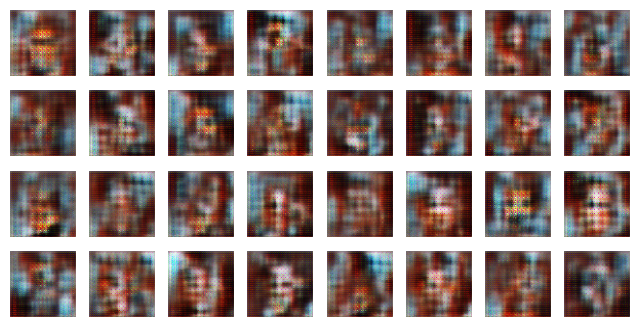

Epoch 2/20


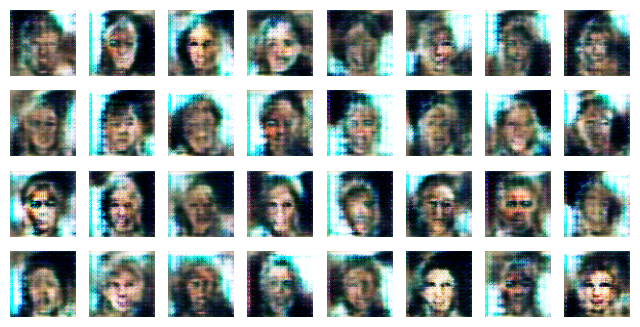

Epoch 3/20


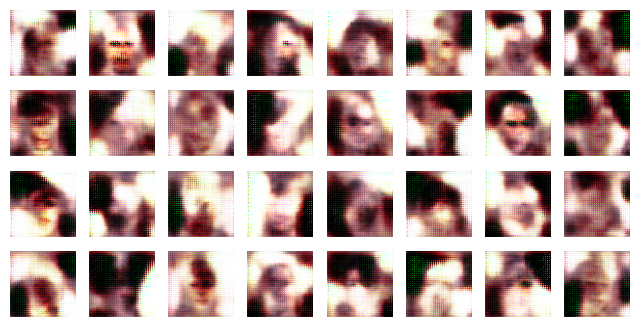

Epoch 4/20


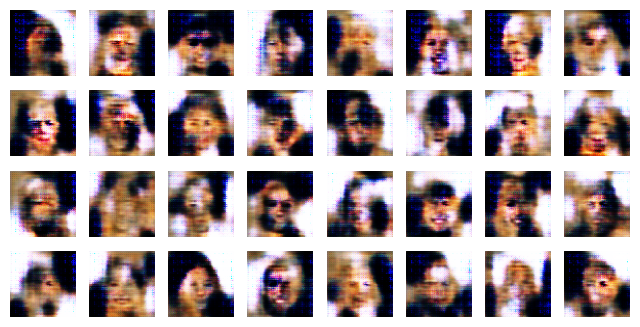

Epoch 5/20


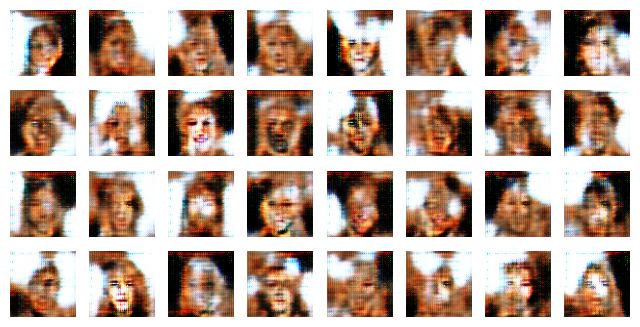

Epoch 6/20


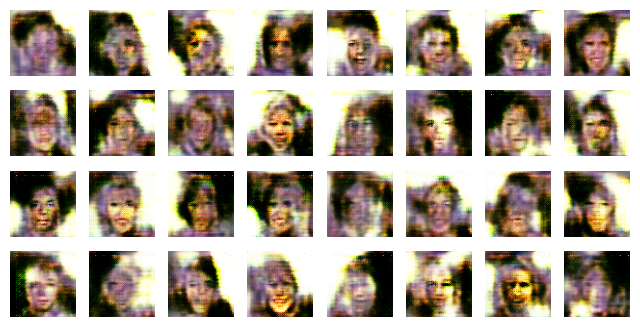

Epoch 7/20


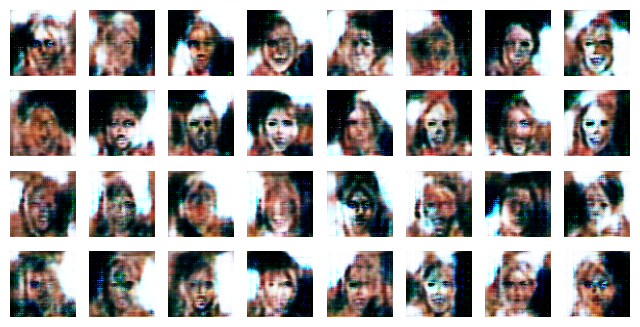

Epoch 8/20


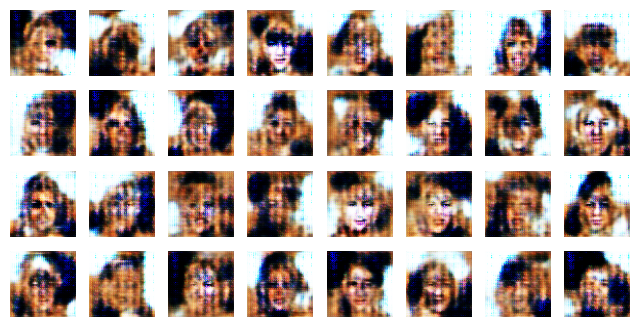

Epoch 9/20


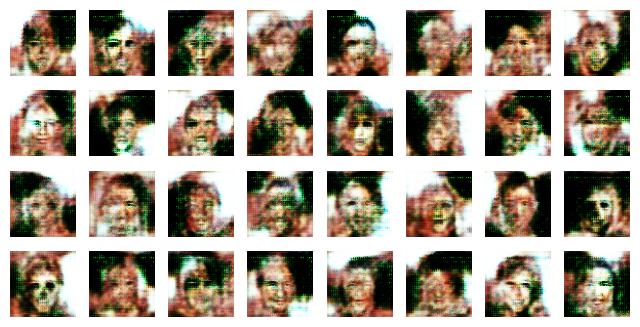

Epoch 10/20


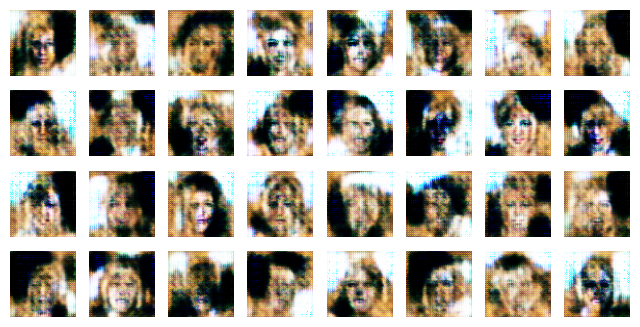

Epoch 11/20


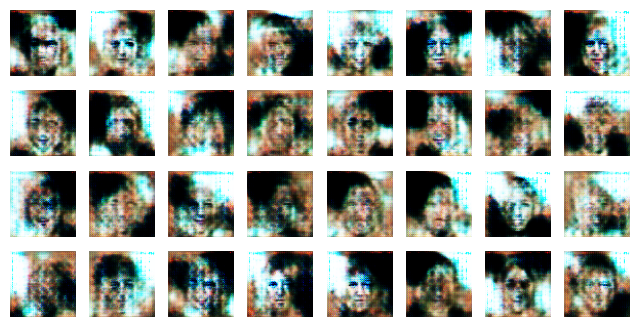

Epoch 12/20


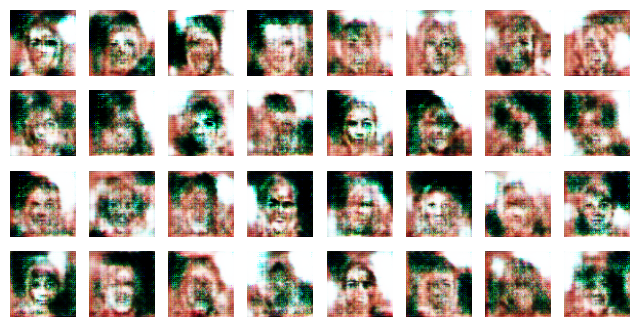

Epoch 13/20


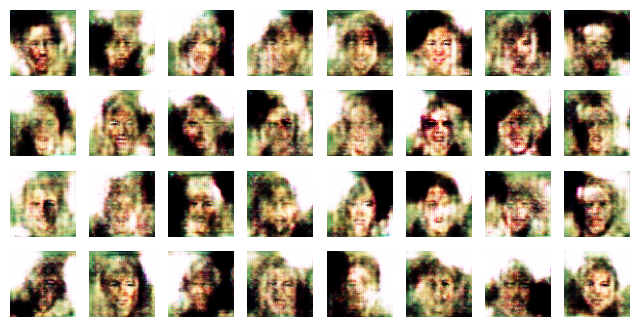

Epoch 14/20


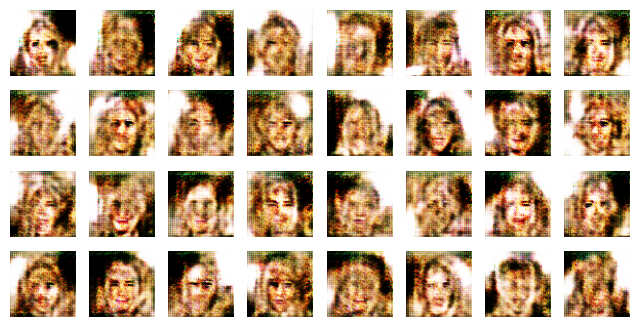

Epoch 15/20


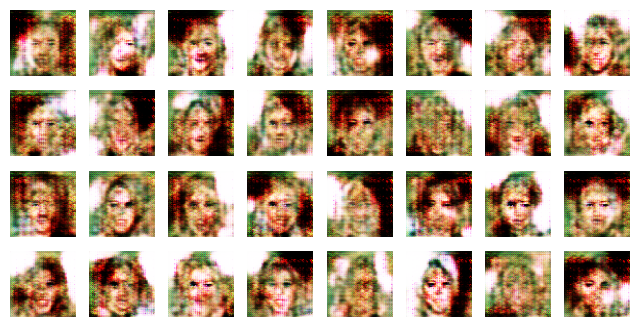

Epoch 16/20


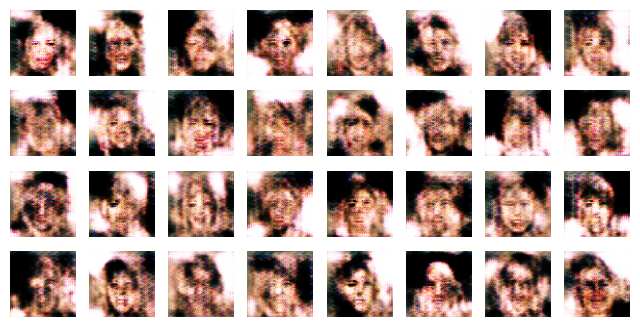

Epoch 17/20


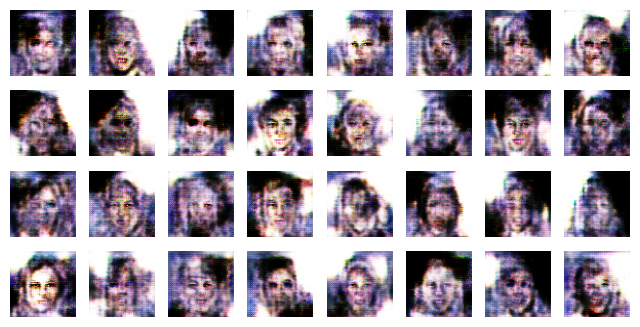

Epoch 18/20


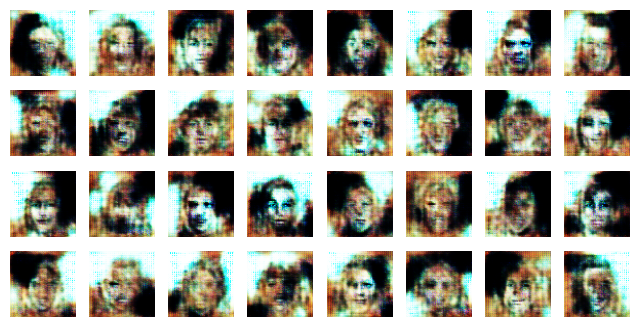

Epoch 19/20


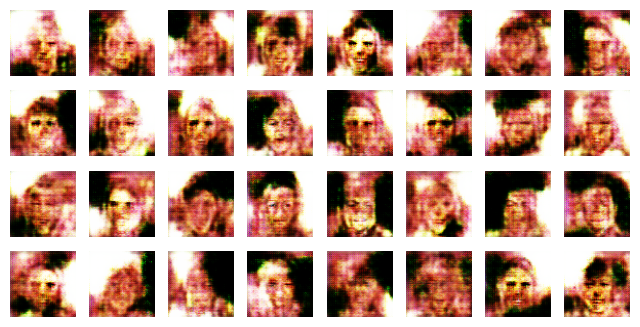

Epoch 20/20


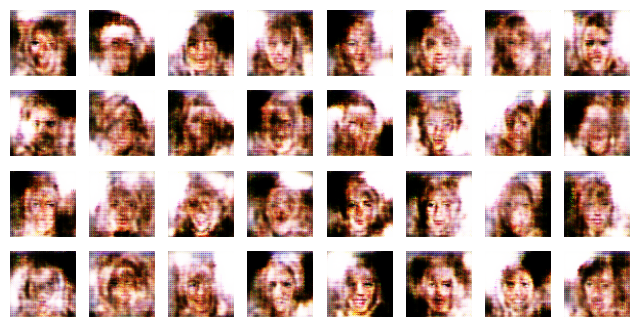

In [ ]:
# 学習の実行
n_epochs = 20
train_gan(gan_model,          # GANのモデル
          celeba_trainset,     # データセット
          batch_size,         # ミニバッチのサイズ
          z_size,             # 入力ベクトルの次元数
          n_epochs=n_epochs)  # 学習回数